In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
import shap
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from TreeModelsFromScratch.DecisionTree import DecisionTree
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import verify_shap_model, smooth_shap, GridSearchCV_scratch, cross_val_score_scratch
from scipy.stats import linregress
import os
from datetime import datetime
import pickle

In [3]:
#load JS vis in the notebook for shap plots
shap.initjs() 

In [4]:
#for storing results
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","strobl_simulation")
today_str = datetime.today().strftime("%Y%m%d")

### Load and clean dataset

The datast from OpenML seems to be ordered and does not come with the PassengerId column. Therefore we use the dataset from kaggle.

In [76]:
# # load dataset
# data = fetch_openml('titanic', version=1)["frame"]
# data.drop(['name', 'boat', 'body', 'home.dest', 'cabin', 'embarked', 'sibsp', 'parch', 'ticket', 'fare'], axis=1, inplace=True)
# data = data[data["age"].notnull()] #filter rows which are nan
# data["sex"] = pd.get_dummies(data["sex"])["female"] #dummy code sex (1==Female)
# data= data.sample(frac=1) #shuffle
# data = data.reset_index(drop=True) #to drop old index
# data = data.reset_index() #to create passengerId feature
# data.rename(columns={"index":"pid"}, inplace=True)

In [77]:
# X = data[['age', 'pclass', 'sex', 'pid']]
# y = data["survived"].astype("float")

In [81]:
data = pd.read_csv("../data/titanic/titanic_train.csv")
data = data[data["Age"].notnull()] #filter rows which are nan
data["Sex"] = pd.get_dummies(data["Sex"])["female"] #dummy code sex (1==Female)

In [82]:
X = data[['Age', 'Pclass', 'Sex', 'PassengerId']]
y = data["Survived"].astype("float")

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

### Fit scratch RF model

In [84]:
rf_scr = RandomForest(n_trees= 100, treetype="classification", 
                    oob=True, oob_SHAP=True, random_state=42)

rf_scr.fit(X_train, y_train)

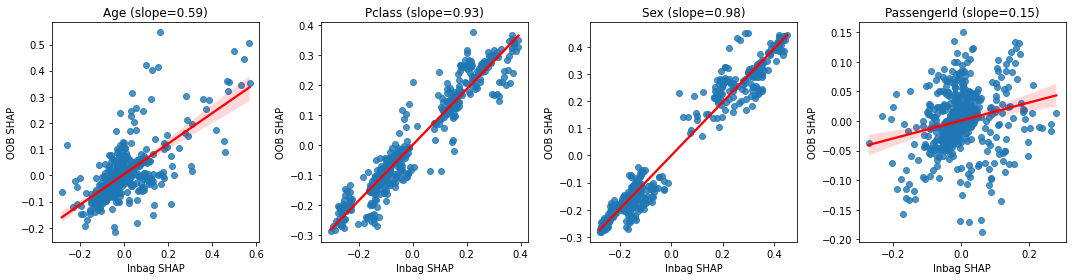

In [85]:
fig, axs = plt.subplots(1,4, figsize=(15,4))

for i in range(4):
    p = sns.regplot(x=rf_scr.inbag_SHAP_values[:, i].reshape(-1, 1), y=rf_scr.oob_SHAP_values[:, i], line_kws={"color": "red"}, ax=axs[i])
    slope, intercept, r_value, p_value, std_err = linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())
    axs[i].set_title(f"{rf_scr.feature_names[i]} (slope={round(slope,2)})")# - regression coef: {np.round(rf_scr.smSHAP_coefs[i],2)}")
    axs[i].set_xlabel("Inbag SHAP")
    axs[i].set_ylabel("OOB SHAP")

#plt.setp(axs, xlim=[0, 0.5], ylim=[0, 0.5]);
plt.tight_layout();

#### Comparison of SHAP values

In [86]:
export_model_rf = rf_scr.export_forest_for_SHAP()

#import model into shap tree explainer
explainer_rf = shap.TreeExplainer(export_model_rf)

# Compute shap scores of RF for train data
shap_vals_rf_raw = explainer_rf.shap_values(X_train, y_train)

In [87]:
smooth_shap_vals, mean_smooth_shap, lin_coefs = smooth_shap(rf_scr.inbag_SHAP_values, rf_scr.oob_SHAP_values)

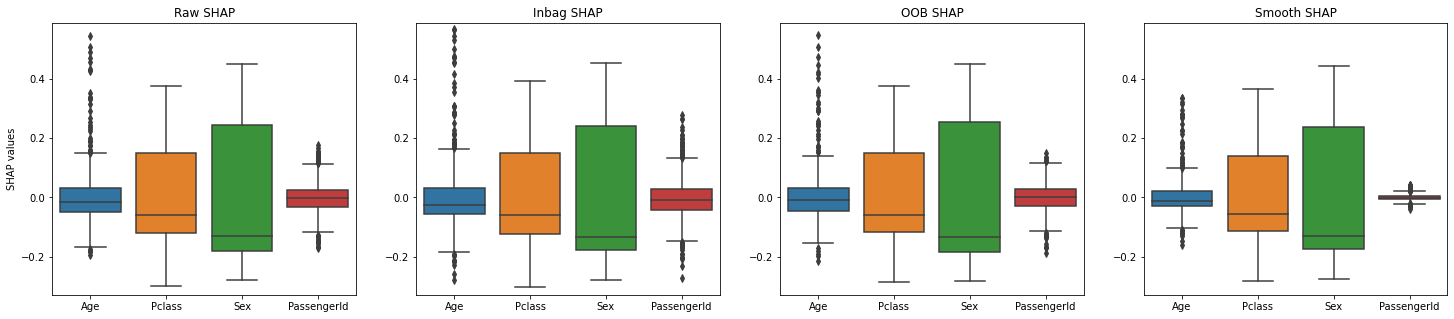

In [88]:
# Comparison of Shap value distribution p feature
fig, axs = plt.subplots(1,4,figsize=(25,5))


sns.boxplot(data=shap_vals_rf_raw, ax =axs[0])
sns.boxplot(data=rf_scr.inbag_SHAP_values, ax=axs[1])
sns.boxplot(data=rf_scr.oob_SHAP_values, ax=axs[2])
sns.boxplot(data=smooth_shap_vals, ax =axs[3])


axs[0].set_title("Raw SHAP")
axs[1].set_title("Inbag SHAP")
axs[2].set_title("OOB SHAP")
axs[3].set_title("Smooth SHAP")
axs[0].set_ylabel("SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3], xticklabels=X_train.columns);

plt.setp(axs, ylim=axs[2].get_ylim());

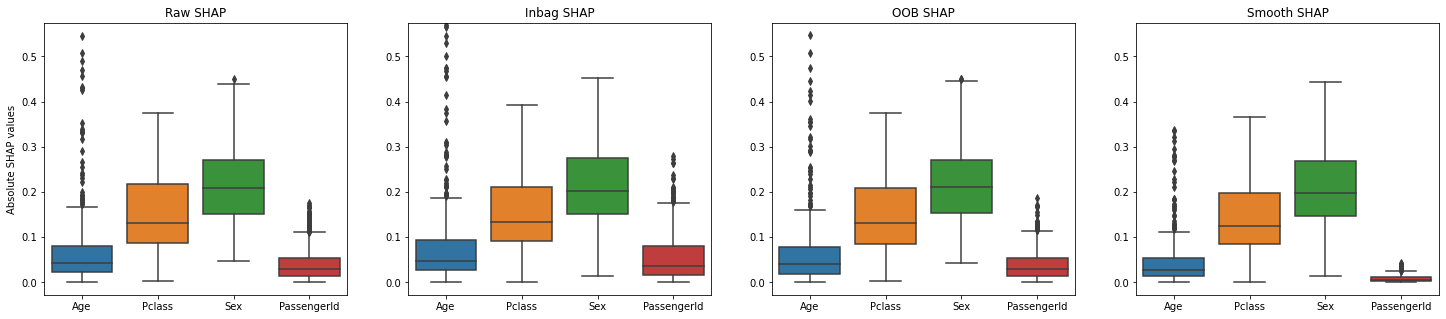

In [89]:
# Comparison of absolute value distribution p feature
fig, axs = plt.subplots(1,4,figsize=(25,5))


sns.boxplot(data=np.abs(shap_vals_rf_raw), ax =axs[0])
sns.boxplot(data=np.abs(rf_scr.inbag_SHAP_values), ax=axs[1])
sns.boxplot(data=np.abs(rf_scr.oob_SHAP_values), ax=axs[2])
sns.boxplot(data=np.abs(smooth_shap_vals), ax =axs[3])


axs[0].set_title("Raw SHAP")
axs[1].set_title("Inbag SHAP")
axs[2].set_title("OOB SHAP")
axs[3].set_title("Smooth SHAP")
axs[0].set_ylabel("Absolute SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3], xticklabels=X_train.columns);

plt.setp(axs, ylim=axs[2].get_ylim());